In [27]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import sklearn_pandas
import matplotlib.pyplot as plt
import random
#from lightgbm import LGBMRegressor
#from xgboost import XGBRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, SimpleRNN, GRU, LSTM, Dropout, Embedding
from keras import regularizers
from nltk.corpus import stopwords
import os
import sys
sys.path.insert(0, '../input/wordbatch/wordbatch/')
import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL, FM_FTRL
import re

In [28]:
data = pd.read_csv('../input/mercari-price-suggestion-challenge/train.tsv', sep='\t')
test = pd.read_csv('../input/mercari-price-suggestion-challenge/test.tsv', sep='\t')
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [29]:
data.price.describe().apply(lambda x: format(x, '.1f'))

count    1482535.0
mean          26.7
std           38.6
min            0.0
25%           10.0
50%           17.0
75%           29.0
max         2009.0
Name: price, dtype: object

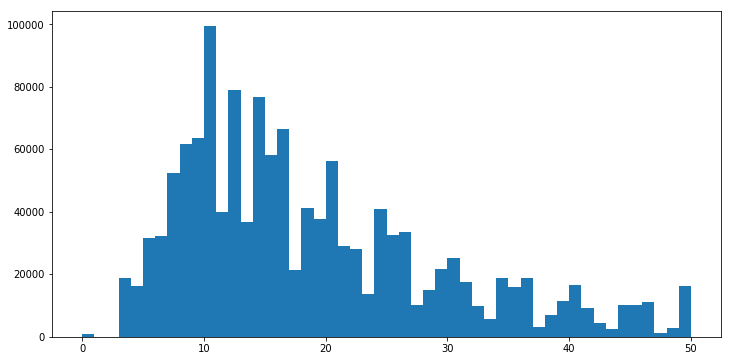

In [30]:
plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(data['price'], bins=50, range=(0,50))

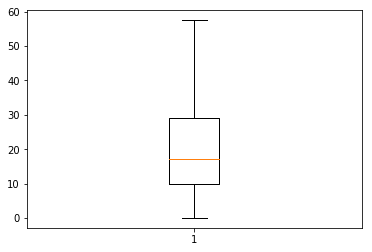

In [31]:
plt.figure()
boxplot = plt.boxplot(data.price, 0, '')

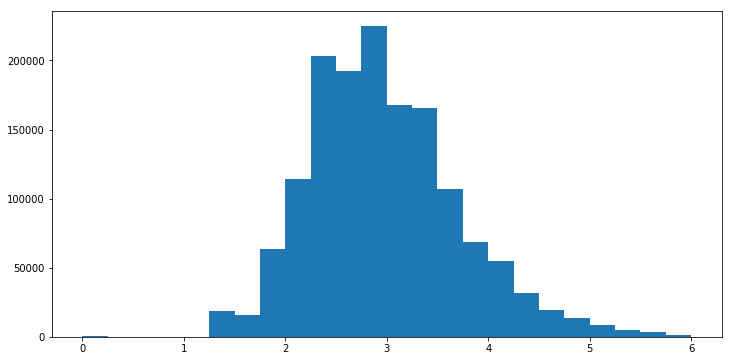

In [32]:
plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(np.log1p(data['price']), bins=24, range=(0,6))

In [33]:
top_brands = data.brand_name.value_counts().head(10)
top_brand_names = top_brands.index
brand_name_means = data.groupby('brand_name')['price'].agg(['median', 'count']).query('count>=100').sort_values(by='median', ascending=False)
top_bottom_brands = pd.concat([brand_name_means.head(5), brand_name_means.tail(5)])
top_bottom_brands

,median,count
brand_name,,
David Yurman,220.0,242
Christian Louboutin,156.0,360
Sherri Hill,151.0,213
Spin Master,110.0,549
Yeezy,107.5,170
Rimmel,7.0,173
Topps,7.0,475
Konami,7.0,1033
Bonne Bell,6.0,215


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


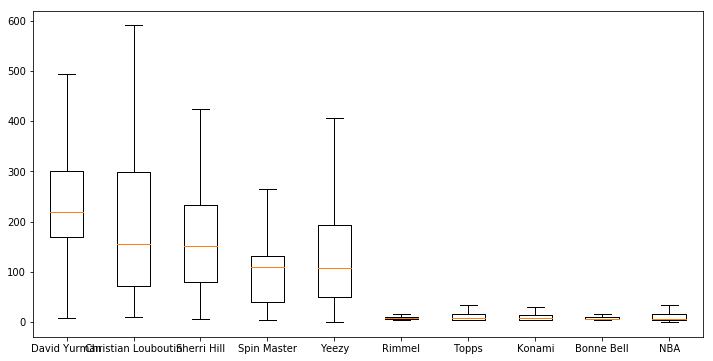

In [34]:
def bp(brand_name):
    return data[data.brand_name == brand_name].price
prices_by_brand = [bp(brand_name) for brand_name in top_bottom_brands.index]
plt.figure(figsize=(12,6))
boxplot = plt.boxplot(prices_by_brand, 0, '', labels=top_bottom_brands.index)

In [35]:
all_brands = data['brand_name'].dropna().value_counts()
all_brands = all_brands.head(2000)
all_brands = set(all_brands.index.values)

In [36]:
def ngrams(text, ngram_range):
    words = text.split()
    for wordcount in range(ngram_range[0], ngram_range[1]+1):
        for i in range(0, len(words)-wordcount+1):
            yield " ".join(words[i:i+wordcount])
            
def match_brand_name(row):
    if row['brand_name'] != "unknown":
        return row['brand_name']
    if row['name'] in all_brands:
        return row['name']
    # Substrings of wordcount 1, 2, 3
    for subname in reversed(list(ngrams(row['name'], (1, 3)))):
        if subname in all_brands:
            return subname
    return row['brand_name']

def fill_brand(data):
    data['brand_name'] = data[['brand_name', 'name']].apply(match_brand_name, axis=1)

In [37]:
#stop = set(stopwords.words('english'))
def prepare_data(data):
    model_data = data
    model_data['name'] = model_data['name'].fillna("unknown")
    model_data['item_description'] = model_data['item_description']\
        .fillna("unknown")\
        .apply(lambda x: x.replace('[rm]', ''))\
        .apply(lambda x: x.replace('No description yet', 'unknown'))
    model_data['brand_name'] = model_data['brand_name'].fillna("unknown")
    fill_brand(model_data)
    model_data['category_name'] = model_data['category_name'].fillna("unknown")
    model_data['main_category'] = model_data['category_name'].fillna("").apply(lambda x: x.split('/')[0] if '/' in x else 'unknown')
    model_data['sub_category'] = model_data['category_name'].fillna("").apply(lambda x: x.split('/')[1] if len(x.split('/')) > 1 else 'unknown')
    model_data['sub_sub_category'] = model_data['category_name'].fillna("").apply(lambda x: x.split('/')[2] if len(x.split('/')) > 2 else 'unknown')
    model_data['item_condition_id'] = model_data['item_condition_id'].astype(str).fillna("unknown")
    model_data['shipping'] = model_data['item_condition_id'].astype(str).fillna("unknown")
    model_data['description_length'] = model_data['item_description'].apply(lambda x: len(x)/200)
    model_data['name_length'] = model_data['name'].apply(lambda x: len(x)/50)
    
    return model_data


In [38]:
#model_data = prepare_data(data.sample(10000, random_state=42))
#model_data = prepare_data(data)
#model_data['log_price'] = np.log1p(model_data.price)
#X_train, X_test, y_train, y_test = train_test_split(model_data, model_data.log_price, random_state=42, test_size=0.1)

X_train = prepare_data(data)
y_train = np.log1p(data.price)
X_test = prepare_data(test)

len(X_train), len(X_test)

(9000, 1000)

In [39]:
stop = {x: 1 for x in stopwords.words('english')}
non_alphanums = re.compile(u'[^A-Za-z0-9]+')
def normalize_text(text):
    return u" ".join(
        [x for x in [y for y in non_alphanums.sub(' ', text).lower().strip().split(" ")] \
         if len(x) > 1 and x not in stop])
#wb = wordbatch.WordBatch(normalize_text, method='serial', extractor=(WordBag, {"hash_ngrams":2, "hash_ngrams_weights":[0.5, -1.0], "hash_size":2**23, "norm":'l2', "tf":'log', "idf":50.0}))
#wb.dictionary_freeze = True
#wb.fit_transform(X_train['name'])

In [40]:
mapper = sklearn_pandas.DataFrameMapper([
    #('name', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('name', TfidfVectorizer(ngram_range=(1, 2))),
    #('name', wordbatch.WordBatch(normalize_text, extractor=(WordBag, {"hash_ngrams":2, "hash_ngrams_weights":[0.5, -1.0], "hash_size":2**23, "norm":'l2', "tf":'log', "idf":50.0}), procs=8)),
    ('main_category', CountVectorizer(token_pattern='.+')),
    ('sub_category', CountVectorizer(token_pattern='.+')),
    ('sub_sub_category', CountVectorizer(token_pattern='.+', max_features=1000)),
    ('brand_name', CountVectorizer(token_pattern='.+', max_features=2000)),
    #('item_description', TfidfVectorizer(max_features=50000, ngram_range=(1, 2))),
    ('item_description', TfidfVectorizer(ngram_range=(1, 2))),
    ('item_condition_id', CountVectorizer(token_pattern='.+')),
    ('shipping', CountVectorizer(token_pattern='.+')),
    ('description_length', None),
    ('name_length', None)
], sparse=True)

In [53]:
model = Pipeline([
    ('map', mapper),
    ('reg', Ridge(alpha=3.0))
])


In [54]:
%%time
model.fit(X_train, y_train)

CPU times: user 2.61 s, sys: 24 ms, total: 2.64 s
Wall time: 2.64 s


Pipeline(memory=None,
     steps=[('map', DataFrameMapper(default=False, df_out=False,
        features=[('name', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
      ...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [55]:
y = model.predict(X_test)
y[y < 0] = 0

In [56]:
#w = 0.4
#y = w*y1 + (1-w)*y2

#print("MAE", metrics.mean_absolute_error(np.expm1(y_test.values), np.expm1(y)))
#print("RMSLE", metrics.mean_squared_log_error(np.expm1(y_test.values), np.expm1(y)) ** 0.5)
#print("RMSLE", metrics.mean_squared_log_error(y_test.values, y2) ** 0.5)

RMSLE 0.542319560149


In [45]:
#baseline = np.median(y_train)
#baseline_y = [baseline] * len(y_test)

In [46]:
#print(metrics.mean_absolute_error(np.expm1(y_test), np.expm1(baseline_y)))
#print(metrics.mean_squared_log_error(np.expm1(y_test), np.expm1(baseline_y)) ** 0.5)

In [47]:
#some_index = random.randint(1, len(X_test))
#print(X_test.iloc[some_index])
#print("price: ", np.expm1(y_test.iloc[some_index]))
#print("predicted: ", np.expm1(y[some_index]))

In [48]:
product = {
    "name": "Ray-Ban sunglasses",
    "item_condition_id": 1,
    "category_name": "Men/Men's Accessories/Sunglasses",
    "brand_name": "Ray-Ban",
    "shipping": 0,
    "item_description": "Brand new, original blue-tinted stylish Ray-Ban sunglasses in unopened box"
}
#product1 = pd.DataFrame([product], columns=product.keys())
#product2 = prepare_data(product1)
#product3 = mapper2.transform(product2)
#product4 = model2.predict(product3)
#np.expm1(product4)

In [49]:
results = pd.DataFrame({'test_id': X_test['test_id'], 'price': np.expm1(y)}, columns=['test_id', 'price'])
results.to_csv('submission_keras.csv', index=False)

KeyError: 'test_id'